In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import pickle
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

from ti import *

# Load data (SPY only)

In [2]:
# # load the xlsx file
# def load_xlsx(file):
#     # read the xlsx file from the 5th line with header, only keep the first ns
#     df = pd.read_excel(file, header=5, usecols=[0, 1, 2, 3, 4, 5, 6])
#     return df

# data = load_xlsx("./data/stocks.xlsx")
# # only keep the 1st and 2nd column, name the first one as "Date" and the second one as "Price"
# data.columns = ["date", "close", "open", "low", "high", "3m_iv", "short_interest_rate"]


# # data.dropna(inplace=True)
# data.drop_duplicates(inplace=True)
# # data[['3m_iv', 'short_interest_rate']].ffill(inplace=True)

# # convert the "Date" column to datetime
# data["date"] = pd.to_datetime(data["date"])
# print(data.head())
# print(data.tail())

In [3]:
# data.to_csv(
#     './data/spy.csv'
# )

# Load from new csv

In [18]:
df = pd.read_csv("./data/spy.csv").iloc[:, 1:]

df

,date,close,open,low,high,3m_iv,short_interest_rate
0,2006-02-07,125.48,126.30,125.400,126.660,NaN,NaN
1,2006-02-08,126.62,125.88,125.600,126.780,NaN,NaN
2,2006-02-09,126.41,126.85,126.370,127.600,NaN,NaN
3,2006-02-10,126.64,126.42,125.450,127.130,NaN,NaN
4,2006-02-13,126.41,126.57,125.950,126.790,NaN,NaN
...,...,...,...,...,...,...,...
4561,2024-03-22,521.21,522.11,520.970,522.605,12.6662,NaN
4562,2024-03-25,519.77,519.80,519.610,520.950,12.6790,NaN
4563,2024-03-26,518.81,521.23,518.400,521.580,12.7001,NaN
4564,2024-03-27,523.17,521.71,519.485,523.210,12.6752,NaN


In [19]:
df.columns

Index(['date', 'close', 'open', 'low', 'high', '3m_iv', 'short_interest_rate'], dtype='object')

# Selected df

In [20]:
sele_df = df[["date", "close", "open", "low", "high"]].copy()

sele_df.dropna(inplace=True)

sele_df["date"] = pd.to_datetime(sele_df["date"])

# sele_df = sele_df[(sele_df['date'] >= '2015-01-01') & (sele_df['date'] <= '2019-12-31')]

sele_df.set_index("date", inplace=True)

sele_df

,close,open,low,high
date,,,,
2006-02-07,125.48,126.30,125.400,126.660
2006-02-08,126.62,125.88,125.600,126.780
2006-02-09,126.41,126.85,126.370,127.600
2006-02-10,126.64,126.42,125.450,127.130
2006-02-13,126.41,126.57,125.950,126.790
...,...,...,...,...
2024-03-22,521.21,522.11,520.970,522.605
2024-03-25,519.77,519.80,519.610,520.950
2024-03-26,518.81,521.23,518.400,521.580


# Lags and Rolling Window Length

In [21]:
lags_period = [1, 3, 5, 8, 21]

# Set 1: Only price data 
Open, high, low, close

In [30]:
# Set X and y
X = sele_df[["close", "open", "low", "high"]][
    (sele_df.index >= "2015-01-01") & (sele_df.index <= "2019-12-31")
]
y = sele_df["close"][(sele_df.index >= "2015-01-01") & (sele_df.index <= "2019-12-31")]

In [31]:
def add_lagged_features(X, lags_period):
    lag_X = pd.DataFrame()
    for lag in lags_period:
        for column in np.unique(X.columns):
            lag_X[f"{column}_lag_{lag}"] = X[column].shift(lag)
    return lag_X.dropna()


def prepare_X_y(X, y, lags_period, test_size=0.2):
    if lags_period != None:
        # Add lagged features
        lag_X = add_lagged_features(X, lags_period)
        # Align target variable y with the rows in lag_X
        y_aligned = y.loc[lag_X.index]
    else:
        lag_X = X
        y_aligned = y

    # Calculate split index
    split_idx = int(len(lag_X) * (1 - test_size))

    # Split into training and testing sets based on the calculated index
    X_train = lag_X.iloc[:split_idx]
    X_test = lag_X.iloc[split_idx:]
    y_train = y_aligned.iloc[:split_idx]
    y_test = y_aligned.iloc[split_idx:]

    return (X_train, X_test, y_train, y_test)

In [32]:
only_price = prepare_X_y(X, y, lags_period, test_size=0.2)

print("train time period")
print(only_price[0].index[0], only_price[0].index[-1])
print("test time period")
print(only_price[1].index[0], only_price[1].index[-1])


# pickle_file_path = "./data/only_price.pkl"  # Adjust path as necessary
# with open(pickle_file_path, "wb") as file:
#     pickle.dump(only_price, file)

# print(f"Datasets saved to {pickle_file_path}")

train time period
2015-02-03 00:00:00 2019-01-07 00:00:00
test time period
2019-01-08 00:00:00 2019-12-31 00:00:00


In [33]:
only_price[0]

,close_lag_1,high_lag_1,low_lag_1,open_lag_1,close_lag_3,high_lag_3,low_lag_3,open_lag_3,close_lag_5,high_lag_5,low_lag_5,open_lag_5,close_lag_8,high_lag_8,low_lag_8,open_lag_8,close_lag_21,high_lag_21,low_lag_21,open_lag_21
date,,,,,,,,,,,,,,,,,,,,
2015-02-03,201.92,202.03,197.86,200.05,201.9902,202.30,198.68,200.38,202.7400,204.1200,201.74,202.97,206.10,206.2600,202.33,203.99,205.43,206.88,204.1800,206.38
2015-02-04,204.84,204.85,202.55,203.00,199.4500,202.17,199.13,200.57,200.1400,204.2900,199.91,204.17,204.97,206.1000,204.81,205.79,201.72,204.37,201.3500,204.17
2015-02-05,204.06,205.38,203.51,203.92,201.9200,202.03,197.86,200.05,201.9902,202.3000,198.68,200.38,205.45,205.5600,203.85,204.71,199.82,202.72,198.8550,202.09
2015-02-06,206.12,206.30,204.77,204.86,204.8400,204.85,202.55,203.00,199.4500,202.1700,199.13,200.57,202.74,204.1200,201.74,202.97,202.31,202.72,200.8800,201.42
2015-02-09,205.55,207.24,204.92,206.56,204.0600,205.38,203.51,203.92,201.9200,202.0300,197.86,200.05,200.14,204.2900,199.91,204.17,205.90,206.16,203.9900,204.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,247.75,251.40,246.45,249.58,246.1800,246.18,233.76,235.97,240.7000,249.7100,239.98,246.74,255.08,257.9500,253.28,257.20,274.58,274.58,268.3272,269.60
2019-01-02,249.92,250.19,247.47,249.56,248.0700,248.29,238.96,242.57,234.3400,240.8355,234.27,239.04,251.26,259.4000,249.35,255.17,273.98,275.55,272.4300,273.71
2019-01-03,250.18,251.21,245.95,245.98,247.7500,251.40,246.45,249.58,246.1800,246.1800,233.76,235.97,247.17,251.6200,244.65,249.86,275.65,276.28,273.4500,273.81


# Set 2: Price and Technical Indicators

In [34]:
from ti import *

In [35]:
sele_ti_df = (
    pd.concat([sele_df, pd.concat(technical_indicators(sele_df), axis=1)], axis=1)
    .T.drop_duplicates()
    .T
)
sele_ti_df

,close,open,low,high,ADX,APO,AROONOSC,BOP,CCI,CMO,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
date,,,,,,,,,,,,,,,,,,,,,
2006-02-07,125.48,126.30,125.400,126.660,NaN,NaN,NaN,-0.650794,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2006-02-08,126.62,125.88,125.600,126.780,NaN,NaN,NaN,0.627119,NaN,NaN,...,NaN,NaN,NaN,1.300,NaN,NaN,NaN,NaN,NaN,0.0
2006-02-09,126.41,126.85,126.370,127.600,NaN,NaN,NaN,-0.357724,NaN,NaN,...,NaN,NaN,NaN,1.230,NaN,NaN,NaN,NaN,NaN,0.0
2006-02-10,126.64,126.42,125.450,127.130,NaN,NaN,NaN,0.130952,NaN,NaN,...,NaN,NaN,NaN,1.680,NaN,NaN,NaN,NaN,NaN,0.0
2006-02-13,126.41,126.57,125.950,126.790,NaN,NaN,NaN,-0.190476,NaN,NaN,...,NaN,NaN,NaN,0.840,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,521.21,522.11,520.970,522.605,25.962336,3.031429,85.714286,-0.550459,151.403298,31.960840,...,503.261697,4.623625,0.887094,1.635,510.370636,516.759364,24.069800,-1.721653,-5.978936,1.0
2024-03-25,519.77,519.80,519.610,520.950,25.802733,2.877143,85.714286,-0.022388,99.382761,26.909109,...,504.043488,4.407651,0.848000,1.600,510.776971,518.083029,25.258255,-2.925568,5.839131,1.0
2024-03-26,518.81,521.23,518.400,521.580,25.361118,2.857500,28.571429,-0.761006,73.773353,23.514373,...,504.883973,4.319962,0.832667,3.180,510.949381,517.910619,25.451842,1.475988,15.584334,1.0


In [38]:
X_ti = sele_ti_df[
    (sele_ti_df.index >= "2015-01-01") & (sele_ti_df.index <= "2019-12-31")
]
y_ti = sele_ti_df["close"][
    (sele_ti_df.index >= "2015-01-01") & (sele_ti_df.index <= "2019-12-31")
]

In [39]:
price_ti = prepare_X_y(X_ti, y_ti, lags_period, test_size=0.2)

print("train time period")
print(price_ti[0].index[0], price_ti[0].index[-1])
print("test time period")
print(price_ti[1].index[0], price_ti[1].index[-1])


pickle_file_path = "./data/price_ti.pkl"  # Adjust path as necessary
with open(pickle_file_path, "wb") as file:
    pickle.dump(price_ti, file)

print(f"Datasets saved to {pickle_file_path}")

train time period
2015-02-03 00:00:00 2019-01-07 00:00:00
test time period
2019-01-08 00:00:00 2019-12-31 00:00:00
Datasets saved to ./data/price_ti.pkl


# ***New (stocks_long.csv)***

In [152]:
def fill_short_interest_ratio(df):
    """Fill missing short interest ratio values with forward fill"""
    # find columns with short interest ratio
    selected_columns = list(filter(lambda x: "SHORT INTEREST RATIO" in x, df.columns))

    # Forward fill missing values
    df.loc[:, selected_columns] = df.loc[:, selected_columns].ffill()

    return df

In [153]:
df = pd.read_csv("./data/stocks_long.csv")

df["DATE"] = pd.to_datetime(df["DATE"])

# df = fill_short_interest_ratio(df)

# df.set_index("DATE", inplace=True)

# df.dropna(inplace=True)

df.rename(
    columns={
        "SPY_HIGH": "high",
        "SPY_LAST": "close",
        "SPY_LOW": "low",
        "SPY_OPEN": "open",
    },
    inplace=True,
)

sele_ti_df = (
    pd.concat([df, pd.concat(technical_indicators(df), axis=1)], axis=1)
    .T.drop_duplicates()
    .T
)

sele_ti_df

,DATE,SPY_3M IMPLIED VOL,high,close,low,open,SPY_SHORT INTEREST RATIO,XBI_3M IMPLIED VOL,XBI_HIGH,XBI_LAST,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
0,2006-02-06,NaN,126.8,126.6,126.17,126.44,NaN,NaN,16.5,16.4167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2006-02-07,NaN,126.66,125.48,125.4,126.3,NaN,NaN,16.52,16.3667,...,NaN,NaN,NaN,1.26,NaN,NaN,NaN,NaN,NaN,0
2,2006-02-08,NaN,126.78,126.62,125.6,125.88,NaN,NaN,16.36,16.36,...,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,0
3,2006-02-09,NaN,127.6,126.41,126.37,126.85,NaN,NaN,16.7233,16.5133,...,NaN,NaN,NaN,1.23,NaN,NaN,NaN,NaN,NaN,0
4,2006-02-10,NaN,127.13,126.64,125.45,126.42,NaN,NaN,16.56,16.56,...,NaN,NaN,NaN,1.68,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4562,2024-03-22,12.6662,522.605,521.21,520.97,522.11,NaN,30.7593,95.38,93.56,...,503.261697,4.623625,0.887094,1.635,510.370636,516.759364,24.0698,-1.721653,-5.978936,1
4563,2024-03-25,12.679,520.95,519.77,519.61,519.8,NaN,30.7668,94.47,92.67,...,504.043488,4.407651,0.848,1.6,510.776971,518.083029,25.258255,-2.925568,5.839131,1
4564,2024-03-26,12.7001,521.58,518.81,518.4,521.23,NaN,30.7501,94.46,92.69,...,504.883973,4.319962,0.832667,3.18,510.949381,517.910619,25.451842,1.475988,15.584334,1
4565,2024-03-27,12.6752,523.21,523.17,519.485,521.71,NaN,30.6874,94.92,94.91,...,505.674009,4.325679,0.826821,4.4,510.947591,517.912409,25.018643,6.333264,13.366017,1


In [154]:
# dropna for tweet sentiment
sele_ti_df.dropna(subset="tweet_sentiment", inplace=True)

sele_ti_df

,DATE,SPY_3M IMPLIED VOL,high,close,low,open,SPY_SHORT INTEREST RATIO,XBI_3M IMPLIED VOL,XBI_HIGH,XBI_LAST,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
1861,2013-06-28,NaN,161.4,160.42,159.86,160.63,1.293,NaN,35.0667,34.7533,...,157.422157,2.210204,1.377761,1.54,160.358218,161.961782,24.685862,-6.372128,-3.146592,1
1947,2013-10-30,NaN,177.51,176.29,175.66,177.38,NaN,NaN,41.7633,40.1167,...,164.64297,1.492377,0.846547,1.85,172.927595,169.112405,23.575423,1.957739,-3.689588,1
2007,2014-01-28,NaN,179.3,179.07,178.12,178.14,NaN,NaN,50.9433,50.6867,...,179.007808,1.629926,0.910217,1.29,180.299221,181.760779,19.512848,0.138396,-2.040988,1
2017,2014-02-11,NaN,182.439,181.98,180.0389,180.16,NaN,NaN,52.2,52.0067,...,173.519071,1.956508,1.075123,2.429,179.485223,179.164777,20.55177,-3.326307,2.554261,1
2025,2014-02-24,NaN,186.15,184.91,184.2,184.28,NaN,NaN,55.9733,55.5033,...,173.673673,1.836673,0.993279,2.26,180.822052,179.037948,24.674143,3.648168,-1.835234,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,2019-12-24,12.9785,321.52,321.23,320.9,321.47,NaN,26.0051,98.77,98.46,...,308.91266,1.913826,0.595781,0.62,315.707815,313.396385,22.355996,4.93228,-2.853776,1
3496,2019-12-26,12.9736,322.95,322.94,321.64,321.65,NaN,26.0141,98.79,97.61,...,308.841339,1.899982,0.588339,1.72,316.733905,313.346095,21.679514,3.076909,-3.544026,1
3497,2019-12-27,12.9749,323.8,322.86,322.28,323.74,NaN,26.0757,98.08,96.24,...,308.76074,1.87284,0.580078,1.52,317.659182,313.270818,21.213283,2.512045,-2.020154,1
3498,2019-12-30,12.9999,323.1,321.08,320.55,322.95,NaN,26.139,96.46,94.76,...,309.001702,1.921209,0.598358,2.55,317.590583,313.339417,20.972442,2.004672,-1.86385,1


In [155]:
sele_ti_df = fill_short_interest_ratio(sele_ti_df)
sele_ti_df

,DATE,SPY_3M IMPLIED VOL,high,close,low,open,SPY_SHORT INTEREST RATIO,XBI_3M IMPLIED VOL,XBI_HIGH,XBI_LAST,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
1861,2013-06-28,NaN,161.4,160.42,159.86,160.63,1.293,NaN,35.0667,34.7533,...,157.422157,2.210204,1.377761,1.54,160.358218,161.961782,24.685862,-6.372128,-3.146592,1
1947,2013-10-30,NaN,177.51,176.29,175.66,177.38,1.293,NaN,41.7633,40.1167,...,164.64297,1.492377,0.846547,1.85,172.927595,169.112405,23.575423,1.957739,-3.689588,1
2007,2014-01-28,NaN,179.3,179.07,178.12,178.14,1.293,NaN,50.9433,50.6867,...,179.007808,1.629926,0.910217,1.29,180.299221,181.760779,19.512848,0.138396,-2.040988,1
2017,2014-02-11,NaN,182.439,181.98,180.0389,180.16,1.293,NaN,52.2,52.0067,...,173.519071,1.956508,1.075123,2.429,179.485223,179.164777,20.55177,-3.326307,2.554261,1
2025,2014-02-24,NaN,186.15,184.91,184.2,184.28,1.293,NaN,55.9733,55.5033,...,173.673673,1.836673,0.993279,2.26,180.822052,179.037948,24.674143,3.648168,-1.835234,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,2019-12-24,12.9785,321.52,321.23,320.9,321.47,2.463,26.0051,98.77,98.46,...,308.91266,1.913826,0.595781,0.62,315.707815,313.396385,22.355996,4.93228,-2.853776,1
3496,2019-12-26,12.9736,322.95,322.94,321.64,321.65,2.463,26.0141,98.79,97.61,...,308.841339,1.899982,0.588339,1.72,316.733905,313.346095,21.679514,3.076909,-3.544026,1
3497,2019-12-27,12.9749,323.8,322.86,322.28,323.74,2.463,26.0757,98.08,96.24,...,308.76074,1.87284,0.580078,1.52,317.659182,313.270818,21.213283,2.512045,-2.020154,1
3498,2019-12-30,12.9999,323.1,321.08,320.55,322.95,2.463,26.139,96.46,94.76,...,309.001702,1.921209,0.598358,2.55,317.590583,313.339417,20.972442,2.004672,-1.86385,1


In [156]:
def drop_ticker(df, ticker):
    """Drop a ticker from the dataframe"""
    selected_columns = list(filter(lambda x: ticker not in x, df.columns))
    return df[selected_columns]

In [157]:
# drop columns with lots of missing values
sele_ti_df = drop_ticker(drop_ticker(drop_ticker(sele_ti_df, "XLC"), "XLRE"), "XLE")

# some columns have 9 missing values at the begining of the data
# forward fill a missing value
sele_ti_df = sele_ti_df.iloc[9:, :].ffill()

sele_ti_df

,DATE,SPY_3M IMPLIED VOL,high,close,low,open,SPY_SHORT INTEREST RATIO,XBI_3M IMPLIED VOL,XBI_HIGH,XBI_LAST,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
2091,2014-05-29,12.4253,192.40,192.37,191.33,191.82,2.431,35.5480,44.8600,44.5700,...,186.052086,1.457459,0.757633,1.07,187.707522,190.702478,18.726638,0.351179,2.895252,1
2100,2014-06-11,12.0743,195.12,194.92,194.48,194.90,2.431,33.7059,50.2567,49.6067,...,186.234186,1.244180,0.638303,1.12,191.918278,190.611722,16.772994,0.805450,0.353470,1
2101,2014-06-12,12.0426,194.80,193.54,193.11,194.65,2.431,33.5534,50.1667,49.6000,...,186.532320,1.284596,0.663737,1.81,191.859265,190.670735,17.908336,1.251643,1.228526,1
2135,2014-07-31,11.2006,195.78,193.09,192.97,195.61,2.673,30.9794,49.7600,48.7333,...,194.765394,1.549645,0.802551,4.01,194.622292,197.407708,17.413968,1.045878,-1.516828,1
2136,2014-08-01,11.3482,193.76,192.50,191.57,192.56,2.673,31.1233,49.3500,48.3500,...,193.784081,1.595385,0.828771,2.19,194.525370,196.104630,17.308202,0.140369,-2.035829,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,2019-12-24,12.9785,321.52,321.23,320.90,321.47,2.463,26.0051,98.7700,98.4600,...,308.912660,1.913826,0.595781,0.62,315.707815,313.396385,22.355996,4.932280,-2.853776,1
3496,2019-12-26,12.9736,322.95,322.94,321.64,321.65,2.463,26.0141,98.7900,97.6100,...,308.841339,1.899982,0.588339,1.72,316.733905,313.346095,21.679514,3.076909,-3.544026,1
3497,2019-12-27,12.9749,323.80,322.86,322.28,323.74,2.463,26.0757,98.0800,96.2400,...,308.760740,1.872840,0.580078,1.52,317.659182,313.270818,21.213283,2.512045,-2.020154,1
3498,2019-12-30,12.9999,323.10,321.08,320.55,322.95,2.463,26.1390,96.4600,94.7600,...,309.001702,1.921209,0.598358,2.55,317.590583,313.339417,20.972442,2.004672,-1.863850,1


In [158]:
sele_ti_df.isnull().sum().sum()

0

In [159]:
sele_ti_df.columns

Index(['DATE', 'SPY_3M IMPLIED VOL', 'high', 'close', 'low', 'open',
       'SPY_SHORT INTEREST RATIO', 'XBI_3M IMPLIED VOL', 'XBI_HIGH',
       'XBI_LAST',
       ...
       'BBANDS_LOWER', 'ATR', 'NATR', 'TRANGE', 'CHANDELIER_EXIT_LONG',
       'CHANDELIER_EXIT_SHORT', 'HT_DCPERIOD', 'HT_PHASOR_inphase',
       'HT_PHASOR_quadrature', 'HT_TRENDMODE'],
      dtype='object', length=111)

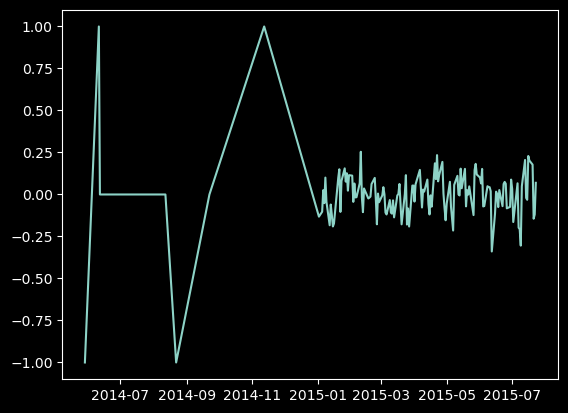

In [160]:
plt.plot(sele_ti_df["DATE"][:150], sele_ti_df["tweet_sentiment"][:150])

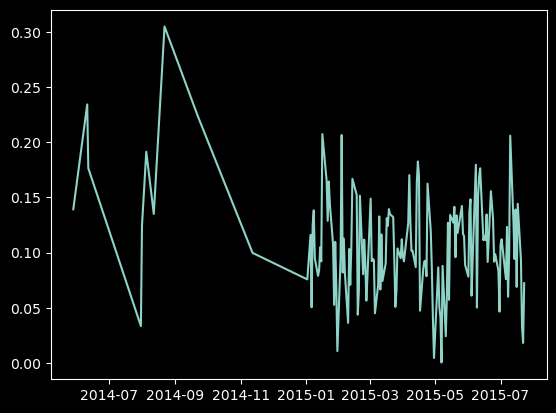

In [161]:
plt.plot(sele_ti_df["DATE"][:150], sele_ti_df["news_sentiment"][:150])

In [163]:
sele_ti_df = sele_ti_df[sele_ti_df["DATE"] >= "2015-01-01"]
sele_ti_df.set_index("DATE", inplace=True)

sele_ti_df

,SPY_3M IMPLIED VOL,high,close,low,open,SPY_SHORT INTEREST RATIO,XBI_3M IMPLIED VOL,XBI_HIGH,XBI_LAST,XBI_LOW,...,BBANDS_LOWER,ATR,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-02,14.0384,206.88,205.43,204.180,206.38,2.673,32.6321,63.3167,62.8033,61.6867,...,199.265139,2.296904,1.118096,2.700,206.240885,204.589115,21.584724,2.537931,-6.082919,0
2015-01-05,14.1676,204.37,201.72,201.350,204.17,2.673,32.9791,64.1600,63.0000,62.2134,...,198.858538,2.424268,1.201799,4.080,205.990390,204.839610,20.649099,1.551261,-3.456028,0
2015-01-06,14.3399,202.72,199.82,198.855,202.09,2.673,33.2660,63.7467,61.4333,60.6667,...,198.193487,2.527178,1.264727,3.865,205.780599,205.049401,19.789482,1.107626,-3.389363,0
2015-01-07,14.4772,202.72,202.31,200.880,201.42,2.673,33.4782,63.9433,63.8900,62.3187,...,197.960416,2.553808,1.262324,2.900,205.711936,205.118064,19.052788,-0.081201,-4.809166,0
2015-01-08,14.5777,206.16,205.90,203.990,204.01,2.673,33.6630,65.3666,65.3067,64.3100,...,197.961837,2.646393,1.285281,3.850,205.516848,205.313152,18.432875,-2.143916,-4.606338,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,12.9785,321.52,321.23,320.900,321.47,2.463,26.0051,98.7700,98.4600,97.3300,...,308.912660,1.913826,0.595781,0.620,315.707815,313.396385,22.355996,4.932280,-2.853776,1
2019-12-26,12.9736,322.95,322.94,321.640,321.65,2.463,26.0141,98.7900,97.6100,97.4800,...,308.841339,1.899982,0.588339,1.720,316.733905,313.346095,21.679514,3.076909,-3.544026,1
2019-12-27,12.9749,323.80,322.86,322.280,323.74,2.463,26.0757,98.0800,96.2400,95.8600,...,308.760740,1.872840,0.580078,1.520,317.659182,313.270818,21.213283,2.512045,-2.020154,1


In [165]:
sele_ti_df.to_csv("./data/stocks_long_w_ti.csv")